In [1]:
import torch
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torchinfo import summary


In [2]:
path = './MURA-v1.1/'
train_image_paths_csv = "train_image_paths.csv"
df_train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
df_train_images_paths.columns = ['image_path']

In [3]:
df_train_images_paths['label'] = df_train_images_paths['image_path'].map(lambda x: 'positive' if 'positive' in x else 'negative')
df_train_images_paths['category'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_train_images_paths['patientId'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [4]:
valid_image_paths_csv = "valid_image_paths.csv"
df_valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
df_valid_data_paths.columns = ['image_path']

In [5]:
df_valid_data_paths['label'] = df_valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
df_valid_data_paths['category']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_valid_data_paths['dir'] =  df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
#df_valid_data_paths['patientId']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [6]:
df_train_images_paths["label"] = df_train_images_paths["label"].replace({'positive': 1, 'negative': 0})


In [7]:
df_valid_data_paths["label"] = df_valid_data_paths["label"].replace({'positive': 1, 'negative': 0})


# The Model

In [8]:
densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121')

Using cache found in C:\Users\Hamad/.cache\torch\hub\pytorch_vision_v0.10.0


In [9]:
from skimage.filters import butterworth
from skimage.filters import gaussian
from skimage import exposure

In [10]:
from torch.utils.data import Dataset
from skimage import img_as_ubyte
from skimage.color import rgb2gray
class MuraDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, device='cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        
        # Convert PIL Image to numpy array
        image_np = np.array(image)
        
        image_gray = rgb2gray(image_np)
        
        # Apply adaptive histogram equalization
        image_gray = exposure.equalize_adapthist(image_gray, clip_limit=0.02)

        
        # Apply Butterworth filter
        image_butterworth = butterworth(image_gray)

        
        # Apply Gaussian filter
        image_gaussian = gaussian(image_gray)
        
        # Combine the two images into one (stack them along the last axis)
        # Create a 3 channel image from the butterworth and gaussian filtered images
        image_combined = np.stack([image_butterworth, image_gaussian, image_gray], axis=-1)
        
        image_combined = (image_combined - np.min(image_combined)) / (np.max(image_combined) - np.min(image_combined))
        
        # Convert to 8-bit image for PIL
        image_combined = img_as_ubyte(image_combined)
        
        # Convert numpy array back to PIL Image
        image = Image.fromarray(image_combined)
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        image = image.to(self.device)
        
        label = torch.tensor(label).to(self.device)

        return image, label


In [11]:
train_label_counts = df_train_images_paths["label"].value_counts()
valid_label_counts = df_valid_data_paths["label"].value_counts()

print("Training Labels Counts:\n", train_label_counts)
print("\nValidation Labels Counts:\n", valid_label_counts)


Training Labels Counts:
 label
0    21935
1    14873
Name: count, dtype: int64

Validation Labels Counts:
 label
0    1667
1    1530
Name: count, dtype: int64


## We noticed some unbalance data so we down sampled it 

In [12]:
# Sampling 
negative_class = df_train_images_paths[ df_train_images_paths['label'] == 0]
postive_class = df_train_images_paths[ df_train_images_paths['label'] == 1]
equal_train_split_negative = negative_class.sample(n=len(postive_class), random_state=62)

In [13]:
len(equal_train_split_negative)

14873

In [14]:
balanced_df = pd.concat([equal_train_split_negative,postive_class],axis=0)

In [15]:
len(df_train_images_paths)

36808

In [16]:
len(balanced_df)

29746

In [17]:
train_balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

mean_values = [0.2665, 0.4648, 0.4648]# Calculated
std_values = [0.1079, 0.1650, 0.1666] # Calculated
batchsize = 32
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),  # Already included
    v2.RandomVerticalFlip(p=0.5),  # New: vertical flip
    v2.RandomRotation(10),  # New: random rotation with a maximum rotation angle of 10 degrees
    v2.Resize((224, 224)),  # Already included
    v2.ToTensor(),  # Already included
    v2.Normalize(mean=mean_values, std=std_values)  # Normalization step

])


val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

Mura_transform = MuraDataset(train_balanced_df["image_path"], train_balanced_df["label"], transform=transform,device='cuda')
train_loader = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)
Mura_transform_valid = MuraDataset(df_valid_data_paths["image_path"], df_valid_data_paths["label"], transform=val_transform,device='cuda')
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)



c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

# I Need to calculate the mean and the std for each channel, Because if i don't the loss function will get lost

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Custom data loader for mean and std calculation without any filters applied 

In [20]:
# from torch.utils.data import Dataset
# from skimage import img_as_ubyte
# from skimage.color import rgb2gray

# class MuraDataset_MeanStd(Dataset):
#     def __init__(self, image_paths, labels, transform=None, device='cpu'):
#         self.image_paths = image_paths
#         self.labels = labels
#         self.transform = transform
#         self.device = device

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.item()
        
#         img_path = self.image_paths[idx]
#         image = Image.open(img_path)
#         image = image.convert('RGB')  # Convert to RGB
        
#         # Convert PIL Image to numpy array and then directly to torch tensor
#         image_np = np.array(image)
#         image = torch.from_numpy(image_np).permute(2, 0, 1).float()  # Convert to CxHxW format
        
#         label = self.labels[idx]
        
#         if self.transform:
#             image = self.transform(image)
        
#         image = image.to(self.device)
#         label = torch.tensor(label).to(self.device)

#         return image, label

# batchsize = 128

# transform = v2.Compose([
#     # v2.RandomHorizontalFlip(p=0.5),  # Already included
#     # v2.RandomVerticalFlip(p=0.5),  # New: vertical flip
#     # v2.RandomRotation(10),  # New: random rotation with a maximum rotation angle of 10 degrees
#     v2.Resize((224, 224)),  # Already included
#     v2.ToTensor(),  # Already included
# ])

# Mura_transform = MuraDataset(train_balanced_df["image_path"], train_balanced_df["label"], transform=transform,device='cuda')
# train_loader_meanStd = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)


In [21]:
# from tqdm import tqdm
# # Initialize psum and psum_sq
# psum = torch.zeros(3).to('cuda' if torch.cuda.is_available() else 'cpu')  # Assuming 3 channels for RGB
# psum_sq = torch.zeros(3).to('cuda' if torch.cuda.is_available() else 'cpu')

# for inputs, _ in tqdm(train_loader_meanStd):  # Unpack the tuple into inputs (images) and _ (labels)
#     psum    += inputs.sum(axis = [0, 2, 3])
#     psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

# num_pixels = len(train_loader_meanStd) * batchsize * 224 * 224  # Assuming every image is resized to 224x224

# mean = psum / num_pixels
# variance = (psum_sq / num_pixels) - mean**2
# std = torch.sqrt(variance)

# print(f"Mean: {mean}")
# print(f"Std: {std}")


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


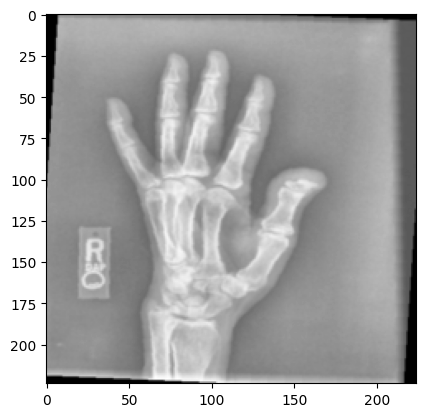

Label: 0


In [22]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Select a single image from the batch.
img = train_features[0]

# Select one channel (e.g., the first channel).
img_channel1 = img[1].cpu().numpy()

# Display the selected channel.
plt.imshow(img_channel1, cmap="gray")
plt.show()

# Alternatively, you can display the second channel
# img_channel2 = img[1].cpu().numpy()
# plt.imshow(img_channel2, cmap="gray")
# plt.show()

label = train_labels[0]
print(f"Label: {label}")


In [23]:
summary(densenet, input_size=(16, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [16, 1000]                --
├─Sequential: 1-1                        [16, 1024, 7, 7]          --
│    └─Conv2d: 2-1                       [16, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [16, 64, 112, 112]        128
│    └─ReLU: 2-3                         [16, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [16, 64, 56, 56]          --
│    └─_DenseBlock: 2-5                  [16, 256, 56, 56]         --
│    │    └─_DenseLayer: 3-1             [16, 32, 56, 56]          45,440
│    │    └─_DenseLayer: 3-2             [16, 32, 56, 56]          49,600
│    │    └─_DenseLayer: 3-3             [16, 32, 56, 56]          53,760
│    │    └─_DenseLayer: 3-4             [16, 32, 56, 56]          57,920
│    │    └─_DenseLayer: 3-5             [16, 32, 56, 56]          62,080
│    │    └─_DenseLayer: 3-6             [16, 32, 56, 56]    

In [24]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, 2)


In [26]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [27]:
densenet.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [28]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [30]:
num_epochs = 20
for epoch in range(num_epochs):
    densenet.train()
    total_loss = 0.0
    correct = 0  # To keep track of correct predictions
    total = 0  # To keep track of total predictions

    batch_accuracies = []  # To store batch accuracies for the epoch

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = densenet(images)

        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        
        _, predicted = outputs.max(1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print loss and accuracy for every 100 batches
        if (batch_idx + 1) % 100 == 0:
            batch_accuracy = 100. * correct / total
            batch_accuracies.append(batch_accuracy)  # Store the batch accuracy
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%")
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total  # Convert to percentage

    # Calculate the average of batch accuracies for the epoch
    avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies) if batch_accuracies else 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.2f}%, Average Batch Accuracy: {avg_batch_accuracy:.2f}%")


Epoch [1/20], Batch [100/930], Batch Loss: 0.6792, Batch Accuracy: 68.81%
Epoch [1/20], Batch [200/930], Batch Loss: 0.6518, Batch Accuracy: 68.17%
Epoch [1/20], Batch [300/930], Batch Loss: 0.7339, Batch Accuracy: 67.43%
Epoch [1/20], Batch [400/930], Batch Loss: 0.4661, Batch Accuracy: 67.59%
Epoch [1/20], Batch [500/930], Batch Loss: 0.5894, Batch Accuracy: 67.36%
Epoch [1/20], Batch [600/930], Batch Loss: 0.5891, Batch Accuracy: 67.49%
Epoch [1/20], Batch [700/930], Batch Loss: 0.6272, Batch Accuracy: 67.43%
Epoch [1/20], Batch [800/930], Batch Loss: 0.5437, Batch Accuracy: 67.42%
Epoch [1/20], Batch [900/930], Batch Loss: 0.6168, Batch Accuracy: 67.32%
Epoch [1/20], Average Loss: 0.5964, Epoch Accuracy: 67.25%, Average Batch Accuracy: 67.67%
Epoch [2/20], Batch [100/930], Batch Loss: 0.5715, Batch Accuracy: 67.50%
Epoch [2/20], Batch [200/930], Batch Loss: 0.4774, Batch Accuracy: 67.38%
Epoch [2/20], Batch [300/930], Batch Loss: 0.5444, Batch Accuracy: 67.53%
Epoch [2/20], Batch [

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Switch the model to evaluation mode
densenet.eval()

# Initialize lists to store all true labels and all predictions
all_labels = []
all_predictions = []    

# Disabling gradient calculation
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(valid_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = densenet(images)  
        

        # Get predictions
        _, predicted = outputs.max(1)

        # Store predictions and true labels for later calculation of metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print status for every 50 batches (or another number if you prefer)
        if (batch_idx + 1) % 100 == 0:
            print(f"Test Batch [{batch_idx+1}/{len(valid_loader)}] Processed")


# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance
recall = recall_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance
f1 = f1_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance

    
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")



Test Batch [100/100] Processed
Test Accuracy: 0.5080
Test Precision: 0.4921
Test Recall: 0.8791
Test F1-Score: 0.6310


In [32]:
import torch
save_path = 'densenet_mura_phase_3_p2_20epoch.pth'
torch.save(densenet,save_path)